# **Image Classification**
---

# 1. Data Understanding
> In this phase we shall load the data

In [2]:
# Importing dependencies
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tqdm
from sklearn.utils import shuffle
import random
import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Convolution2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense, Conv2D, MaxPool2D
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.models import Sequential
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow.keras.utils as Utils

np.random.seed(42)

## 1.1 Loading the data
> In this phase we load the data

In [3]:
# File paths
train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'
val_dir = 'data/seg_pred/'

In [5]:
# Getting the sub classes of the images
# class_names = os.listdir(train_dir)

# # Creating labels for the sub classes
# class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [6]:
# Setting the directories for the subclasses
# train_bgs = 'data/seg_train/seg_train/buildings'
# train_ft = 'data/seg_train/seg_train/forest'
# train_glcr = 'data/seg_train/seg_train/glacier'
# train_mt = 'data/seg_train/seg_train/mountain'
# train_sea = 'data/seg_train/seg_train/sea'
# train_st = 'data/seg_train/seg_train/street'

In [7]:
# Creating objects that stores all images for each of the subclasses
# bgs_train_img = [file for file in os.listdir(train_bgs) if file.endswith('.jpg')]
# ft_train_img = [file for file in os.listdir(train_ft) if file.endswith('.jpg')]
# glc_train_img = [file for file in os.listdir(train_glcr) if file.endswith('.jpg')]
# mt_train_img = [file for file in os.listdir(train_mt) if file.endswith('.jpg')]
# sea_train_img = [file for file in os.listdir(train_sea) if file.endswith('.jpg')]
# st_train_img = [file for file in os.listdir(train_st) if file.endswith('.jpg')]

In [8]:
# Looping through each of the created images to create one larger object
## that houses all the training images
# train_imgs = []
# for image in bgs_train_img:
#     train_imgs.append(image)
# for image in ft_train_img:
#     train_imgs.append(image)
# for image in glc_train_img:
#     train_imgs.append(image)
# for image in mt_train_img:
#     train_imgs.append(image)
# for image in sea_train_img:
#     train_imgs.append(image)
# for image in st_train_img:
#     train_imgs.append(image)

In [4]:
class image_getter (object):
    """ A class with functions to generate images"""
    def __init__(self) -> None:
        pass
    def get_images(directory):
        """ A function to extract images from the file directory"""
        Images = []
        Labels = []
        
        # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
        label = 0
        
        #Main Directory where each class label is present as folder name
        for labels in os.listdir(directory):
            # Folder contain Glacier Images get the '2' class label and so on...
            if labels == 'glacier': 
                label = 2
            elif labels == 'sea':
                label = 4
            elif labels == 'buildings':
                label = 0
            elif labels == 'forest':
                label = 1
            elif labels == 'street':
                label = 5
            elif labels == 'mountain':
                label = 3
            
            # Extracting the file name of the image from Class Label folder
            for image_file in os.listdir(directory+labels):
                
                # Reading the image (OpenCV) 
                image = cv2.imread(directory+labels+r'/'+image_file) 
                
                # Resize the image, Some images are different sizes. (Resizing is very Important)
                image = cv2.resize(image,(150,150))
                
                # Appending  to the list of images and labels created above
                Images.append(image)
                Labels.append(label)
        
        # Shuffle the dataset you just prepared
        return shuffle(Images,Labels,random_state=42) 

    def get_classlabel(class_code):
        labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
        
        return labels[class_code]

In [5]:
# Instantiating an object of image_getter
train_imgs, train_lbs = image_getter.get_images('data/seg_train/seg_train/')

In [6]:
#converting the list of images to numpy array
train_imgs = np.array(train_imgs)
train_lbs = np.array(train_lbs)

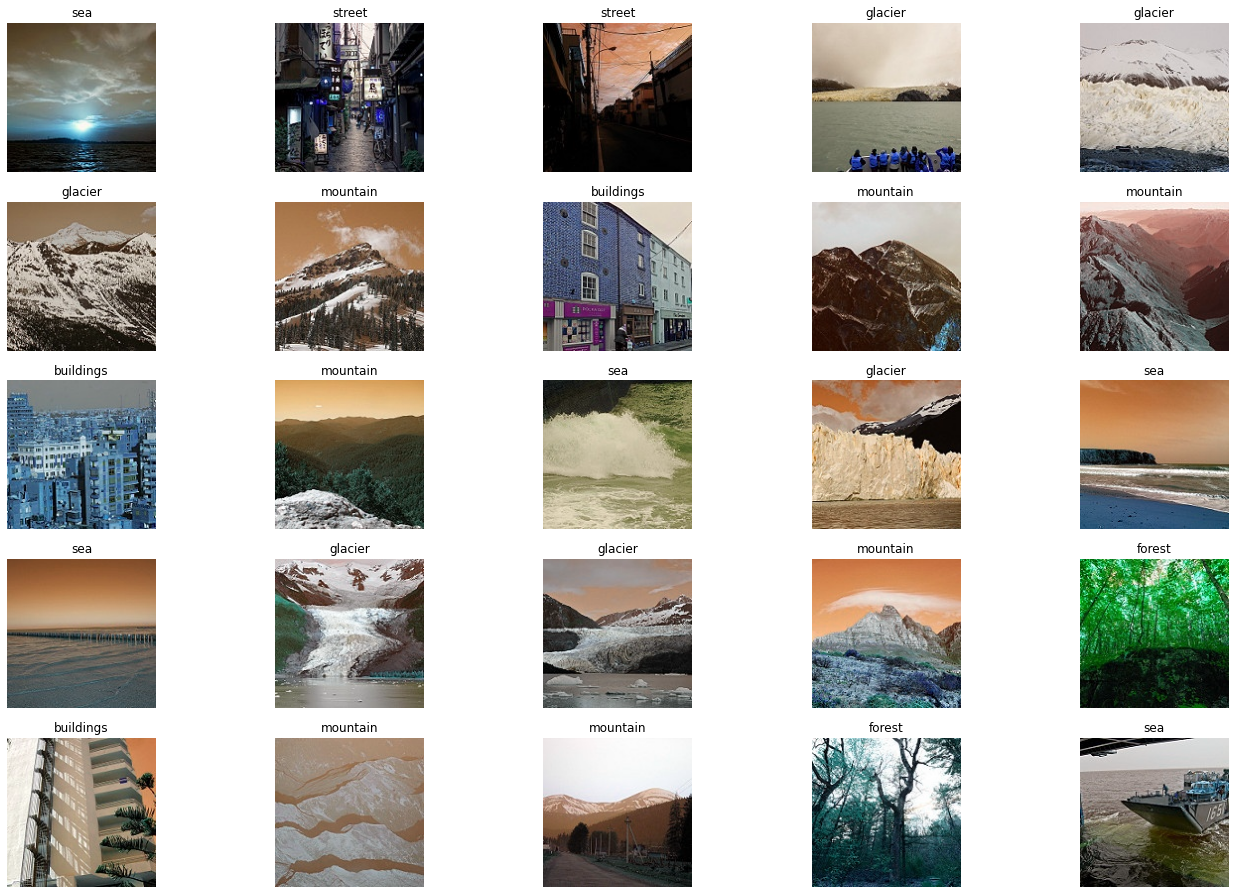

In [7]:
fig, ax = plt.subplots(5,5) 
fig.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0,len(train_imgs))
        ax[i,j].imshow(train_imgs[rnd_number])
        ax[i,j].set_title(image_getter.get_classlabel(train_lbs[rnd_number]))
        ax[i,j].axis('off')

In [8]:
# get all the data in the directory train and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(150, 150), batch_size=14034)

# get all the data in the directory test and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(150, 150), batch_size=3000) 

# get all the data in the directory validation and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(150, 150), batch_size=7301)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [9]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [58]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

In [59]:
# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 14034
Number of testing samples: 3000
Number of validation samples: 7301
train_images shape: (14034, 150, 150, 3)
train_labels shape: (14034, 6)
test_images shape: (3000, 150, 150, 3)
test_labels shape: (3000, 6)
val_images shape: (7301, 150, 150, 3)
val_labels shape: (7301, 1)


In [11]:
class_labels = train_generator.class_indices

In [17]:
# idx_to_classes = {val:key for key, val in dict(train_generator.class_indices).items()}
# idx_to_classes

In [12]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(14034, 67500)
(3000, 67500)
(7301, 67500)


In [13]:
train_y = np.reshape(train_labels[:,0], (14034,1))
test_y = np.reshape(test_labels[:,0], (3000,1))
val_y = np.reshape(val_labels[:,0], (7301,1))

In [14]:
train_y.shape

(14034, 1)

In [25]:
# Build a baseline fully connected model
from keras import models
from keras import layers
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='softmax'))


In [26]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 20)                1350020   
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 147       
_________________________________________________________________
dropout_7 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 40        
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
____________________________________________

In [27]:
history = model.fit(train_img,
                    train_y,
                    epochs=5,
                    verbose=1,
                    validation_data=(test_img, test_y))

Epoch 1/5
439/439 [==============================] - 12s 26ms/step - loss: 0.0000e+00 - acc: 0.1561 - val_loss: 0.0000e+00 - val_acc: 0.1457
Epoch 2/5
439/439 [==============================] - 11s 25ms/step - loss: 0.0000e+00 - acc: 0.1561 - val_loss: 0.0000e+00 - val_acc: 0.1457
Epoch 3/5
439/439 [==============================] - 11s 24ms/step - loss: 0.0000e+00 - acc: 0.1561 - val_loss: 0.0000e+00 - val_acc: 0.1457
Epoch 4/5
439/439 [==============================] - 11s 25ms/step - loss: 0.0000e+00 - acc: 0.1561 - val_loss: 0.0000e+00 - val_acc: 0.1457
Epoch 5/5
439/439 [==============================] - 12s 27ms/step - loss: 0.0000e+00 - acc: 0.1561 - val_loss: 0.0000e+00 - val_acc: 0.1457


In [28]:
results_train = model.evaluate(train_img, train_y)

439/439 [==============================] - 4s 8ms/step - loss: 0.0000e+00 - acc: 0.1561


In [29]:
results_test = model.evaluate(test_img, test_y)

94/94 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - acc: 0.1457


In [30]:
# input_shape = (150,150,3)
# model_alexnet = Sequential()


# model_alexnet.add(Conv2D( 96, 11, strides = 4, activation='relu', input_shape= input_shape))
# model_alexnet.add( MaxPool2D(pool_size = 3, strides = 2) )

# model_alexnet.add(BatchNormalization())

# model_alexnet.add(Conv2D( 256, 5, padding = 'same', activation='relu' ))
# model_alexnet.add( MaxPool2D(pool_size = 3, strides = 2) )

# model_alexnet.add(BatchNormalization())

# model_alexnet.add(Conv2D( 384, 3, padding = 'same', activation='relu'))

# model_alexnet.add(BatchNormalization())

# model_alexnet.add(Conv2D( 384, 3, padding = 'same', activation='relu'))

# model_alexnet.add(BatchNormalization())

# model_alexnet.add(Conv2D( 256, 3, padding = 'same', activation='relu'))

# model_alexnet.add( MaxPool2D(pool_size = 3, strides=2 ))


# # model_alexnet.add( Dropout(0.5) )

# model_alexnet.add( Flatten() )

# model_alexnet.add( Dense(4096, activation='relu' ) )

# # model_alexnet.add( Dropout(0.5) )

# model_alexnet.add( Dense(4096, activation='relu' ) )

# model_alexnet.add( Dense(6, activation='softmax' ) )

# model_alexnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model_alexnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 35, 35, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 17, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 384)        

In [33]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)       

In [ ]:
cnn_history = cnn_model.fit(train_images,
                    train_y,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_images, val_y))

In [45]:
model_3 = Sequential()

model_3.add(Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150, 150, 3)))
model_3.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model_3.add(MaxPool2D(5,5))
model_3.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model_3.add(Conv2D(140,kernel_size=(3,3),activation='relu'))
model_3.add(Conv2D(100,kernel_size=(3,3),activation='relu'))
model_3.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model_3.add(MaxPool2D(5,5))
model_3.add(Flatten())
model_3.add(Dense(180,activation='relu'))
model_3.add(Dense(100,activation='relu'))
model_3.add(Dense(50,activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(6,activation='softmax'))

model_3.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 21, 21, 50)      

## 2. Basic Model with CNN

In [55]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(6, activation='softmax')
])
model_1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 20736)           

In [73]:
model_1.compile(loss="categorical_crossentropy",
              optimizer=Optimizer.Adam(lr=0.0001),
              metrics=['accuracy'])

In [74]:
history_1 = model_1.fit(train_data,
                    epochs=5,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
439/439 [==============================] - 257s 585ms/step - loss: 0.4938 - accuracy: 0.8193 - val_loss: 0.4718 - val_accuracy: 0.8317
Epoch 2/5
439/439 [==============================] - 139s 316ms/step - loss: 0.4754 - accuracy: 0.8268 - val_loss: 0.4565 - val_accuracy: 0.8380
Epoch 3/5
439/439 [==============================] - 137s 313ms/step - loss: 0.4680 - accuracy: 0.8333 - val_loss: 0.4547 - val_accuracy: 0.8367
Epoch 4/5
439/439 [==============================] - 161s 366ms/step - loss: 0.4555 - accuracy: 0.8326 - val_loss: 0.4570 - val_accuracy: 0.8417
Epoch 5/5
439/439 [==============================] - 140s 318ms/step - loss: 0.4571 - accuracy: 0.8328 - val_loss: 0.4860 - val_accuracy: 0.8247


In [62]:
loss_and_acc=model_1.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 20s 208ms/step - loss: 0.5139 - accuracy: 0.8203
Test Loss 0.5138545036315918
Test Accuracy 0.8203333616256714


Text(0, 0.5, 'Loss')

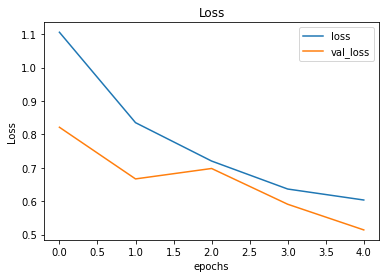

In [63]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')

In [82]:
model_1.predict(train_data)

array([[8.4301777e-02, 2.5574939e-02, 5.8470213e-01, 7.1483783e-02,
        1.5630132e-03, 2.3237436e-01],
       [9.9187181e-04, 7.8514463e-04, 4.6785203e-01, 5.0328964e-01,
        2.6030501e-02, 1.0507953e-03],
       [8.6468151e-03, 4.6899403e-03, 3.8789940e-01, 5.9583563e-01,
        1.3810839e-03, 1.5470636e-03],
       ...,
       [1.3869416e-04, 8.0506376e-05, 9.6577817e-01, 3.1474646e-02,
        1.3477691e-03, 1.1802329e-03],
       [1.8707864e-03, 9.2109330e-03, 1.0574209e-02, 9.6119499e-01,
        1.7144911e-02, 4.2043325e-06],
       [3.6271852e-02, 1.5745618e-03, 7.2189923e-06, 1.2945354e-05,
        5.2450090e-05, 9.6208096e-01]], dtype=float32)

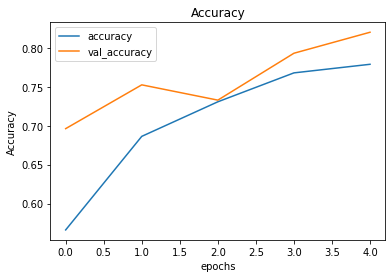

In [64]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

## 3. Transfer Learning Model

In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

### Feature Extraction Model

In [70]:
class_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [72]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (150,150,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_labels))(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [75]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])